# 📑**INTRODUCTION**
<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/en/a/a9/TikTok_logo.svg" alt="Logo TikTok" width="150">
</div>

**TikTok** adalah layanan hosting video berdurasi pendek yang dimiliki oleh perusahaan asal Tiongkok, ByteDance (Wikipedia). Aplikasi ini pertama kali diluncurkan pada tahun 2016 dan meraih popularitas global pada tahun 2020 dengan jumlah unduhan yang melampaui 2 miliar di seluruh dunia. TikTok memperoleh rating 4.5 di Google Play Store. Ulasan pengguna pada platform seperti Google Play Store menjadi sumber masukan yang sangat berharga bagi pengembang untuk mengevaluasi kualitas serta meningkatkan pengalaman pengguna aplikasi. Ulasan-ulasan tersebut tidak hanya mencerminkan opini pengguna, tetapi juga memberikan wawasan yang kaya terhadap berbagai elemen penting dalam aplikasi.


Proyek ini bertujuan untuk mengolah dan menganalisis ulasan pengguna aplikasi TikTok yang bersumber dari dataset publik di Kaggle. Dengan memanfaatkan model kecerdasan buatan IBM Granite, dilakukan analisis sentimen untuk mengidentifikasi persepsi pengguna terhadap berbagai aspek aplikasi. Fokus utama analisis ini adalah mengeksplorasi area-area yang dipandang positif maupun negatif oleh pengguna, serta menyusun rekomendasi berbasis data yang dapat dimanfaatkan oleh pengembang untuk meningkatkan fitur dan kualitas aplikasi.

#⚙️**Setup**

In [87]:
!pip install langchain_community
!pip install replicate

#⚒️**Import Library**

In [88]:
# Mengimport library yang akan digunakan untuk analisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
from wordcloud import WordCloud
from langchain_community.llms import Replicate
import os
from google.colab import userdata
import plotly.express as px
import kagglehub

#🔗**Setup API**

In [89]:
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Setup model
model = "ibm-granite/granite-3.3-8b-instruct"
llm = Replicate(
    model=model,
    replicate_api_token=api_token,
)

# 📊**Data Load**

Data yang digunakan yaitu data publik yang berasal dari [Kaggle](https://www.kaggle.com/datasets/shivkumarganesh/tiktok-google-play-store-review). Data ini berisi ulasan-ulasan penggunak aplikasi TikTok pada Google Play Store. Atribut yang ada pada dataset yaitu

| Nama Kolom       | Deskripsi |
|------------|------|
| UserName       | Nama pengguna   |
| userImage    | Foto profil yang dimiliki pengguna   |
| content    | Ulasan yang dibuat oleh pengguna   |
| score    | Skor/rating antara 1 sampai 5   |
| thumbsUpCount    | Jumlah like yang diterima pengguna   |
| reviewCreatedVersion    | Nomor versi yang digunakan untuk membuat ulasan    |
| at    | Kapan ulasan dibuat   |
| replyContent    | Balasan ulasan dari perusahaan   |
| repliedAt    | Tanggal dan waktu balasan   |
| reviewId    | Kode unik   |

In [90]:
# Mengimport dataset yang berasal dari Kaggle
shivkumarganesh_tiktok_google_play_store_review_path = kagglehub.dataset_download('shivkumarganesh/tiktok-google-play-store-review')

print('Data source import complete.')

Data source import complete.


In [91]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tiktok-google-play-store-review/tiktok_google_play_reviews.csv


In [92]:
# Membaca dataset
df = pd.read_csv('/kaggle/input/tiktok-google-play-store-review/tiktok_google_play_reviews.csv')
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,68ccaec8-1415-4301-a85e-3004679a3a83,Cassie Moore,https://play-lh.googleusercontent.com/a/ALm5wu...,No words,5,0,27.1.3,2022-11-29 21:55:37,NaN,NaN
1,d84cbfd3-6aa3-485c-aaf9-c5dca27dc966,Kaleb Plummer,https://play-lh.googleusercontent.com/a-/ACNPE...,Great fun app so far!,5,0,NaN,2022-11-29 21:55:04,NaN,NaN
2,96618aa1-31e5-4259-8649-89b75d962f00,Rylee Maher,https://play-lh.googleusercontent.com/a/ALm5wu...,The app would get a higher rating but I litera...,1,0,27.1.3,2022-11-29 21:54:48,NaN,NaN
3,078c0bda-598b-474e-a04e-d7cb3e6f6301,Kittykatelyn Romilly,https://play-lh.googleusercontent.com/a-/ACNPE...,I WISH I COULD GIVE THIS A 100 PERCENT RATING ...,5,0,NaN,2022-11-29 21:54:35,NaN,NaN
4,8e68c5cd-b12a-4206-a8da-6bfdbff44ae3,Loveness Malenga,https://play-lh.googleusercontent.com/a-/ACNPE...,Pictures and record,5,0,NaN,2022-11-29 21:54:21,NaN,NaN


In [93]:
# Mengetahui informasi dari dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460287 entries, 0 to 460286
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              460287 non-null  object
 1   userName              460287 non-null  object
 2   userImage             460287 non-null  object
 3   content               460256 non-null  object
 4   score                 460287 non-null  int64 
 5   thumbsUpCount         460287 non-null  int64 
 6   reviewCreatedVersion  333953 non-null  object
 7   at                    460287 non-null  object
 8   replyContent          260 non-null     object
 9   repliedAt             260 non-null     object
dtypes: int64(2), object(8)
memory usage: 35.1+ MB


Dataset ini memuat 460.287 baris ulasan pengguna. Dalam proses analisis sentimen, hanya dua kolom yang dianalisis, yaitu `content` yang berisi isi ulasan, dan `score` yang menunjukkan penilaian pengguna terhadap aplikasi.

In [94]:
# Mengambil kolom content dan score untuk analisis sentimen
df_1=df[['content','score']]
df_1

,content,score
0,No words,5
1,Great fun app so far!,5
2,The app would get a higher rating but I litera...,1
3,I WISH I COULD GIVE THIS A 100 PERCENT RATING ...,5
4,Pictures and record,5
...,...,...
460282,😍😍,5
460283,Very nice,1
460284,Nice,5
460285,TikTok love your sad,5


## 🛠️**Penanganan nilai hilang dan duplikat**

In [95]:
# Mengetahui jumlah nilai yang hilang pada setiap kolom
df_1.isnull().sum()

,0
content,31
score,0


In [96]:
# Menghapus nilai yang hilang
df_1.dropna(inplace=True)

/tmp/ipython-input-96-4046347815.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [97]:
# Mengecek kembali apakah masih terdapat nilai hilang
df_1.isnull().sum()

,0
content,0
score,0


In [98]:
# Mengetahui nilai yang terduplikat
df.duplicated().sum()

np.int64(0)

In [99]:
# Mengetahui type data pada masing-masing kolom
df_1.dtypes

,0
content,object
score,int64


In [100]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460256 entries, 0 to 460286
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   content  460256 non-null  object
 1   score    460256 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.5+ MB


In [101]:
# Menghitung jumlah pengguna yang memberi ulasan pada masing-masing skor
rating_counts = df_1['score'].value_counts().reset_index()
rating_counts.columns = ['score', 'count']

fig = px.pie(rating_counts, names='score', values='count', title='Rating Distribution')
fig.show()

# ⛓️‍**Data Prepocessing**

In [102]:
def clean_text(text):
    if pd.isnull(text):
        return ""

    # Menghapus emoji
    emoji_pattern = re.compile(
        "["u"\U0001F600-\U0001F64F"  # emotikon
        u"\U0001F300-\U0001F5FF"  # simbol & pictogram
        u"\U0001F680-\U0001F6FF"  # transport & simbol lain
        u"\U0001F1E0-\U0001F1FF"  # bendera
        u"\U00002500-\U00002BEF"  # karakter Cina
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)

    # Hapus tag HTML
    text = re.sub(r'<.*?>', '', text)

    # Hapus karakter non-alfabet (kecuali titik, koma, tanda seru, tanda tanya)
    text = re.sub(r"[^a-zA-Z0-9\s.,!?]", '', text)

    # Hapus spasi ganda
    text = re.sub(r'\s+', ' ', text)

    # Strip spasi depan dan belakang
    text = text.strip()

    return text

Dataset yang diambil untuk sampel sebanyak 50 sample publik. Hal ini dilakukan karena keterbatasan API token yang dimiliki.

In [103]:
sample_df = df_1.dropna().sample(n=50, random_state=42).reset_index(drop=True)

# Preprocessing teks
sample_df['content'] = sample_df['content'].apply(clean_text)

# 🖥️**Prompt**

In [104]:
#Membentuk prompt untuk klasifikasi teks dan rangkuman
def build_prompt(reviews, app_name="TikTok"):
    review_text = "\n".join([f"Review {i+1}: {text}" for i, text in enumerate(reviews)])

    prompt = f"""ANALYZE THESE {len(reviews)} TIKTOK REVIEWS FROM GOOGLE PLAY STORE.

# INSTRUCTIONS
1. SENTIMENT: [positive/negative/neutral] (neutral if mixed/unclear)
2. FOCUS AREAS: Choose 1-3 from: features, design, ads, bugs, privacy, performance, updates, notifications
3. KEYWORDS: 3-5 specific keywords/phrases
4. PROBLEM CATEGORY: [bug|ads|performance|login issue|privacy|UI/UX|content moderation|crash|feature removal|N/A]
5. SUMMARY: 1 sentence in Indonesian

# RESPONSE FORMAT
Review 1:
Sentiment: negative
Focus Areas: ads, performance
Keywords: "lag", "too many ads", "buffering"
Problem Category: ads
Summary: Pengguna mengeluhkan terlalu banyak iklan yang mengganggu dan performa aplikasi yang lag.

Review 2:
Sentiment: positive
Focus Areas: features, content
Keywords: "creative", "trending content", "easy editing"
Problem Category: N/A
Summary: Pengguna memuji fitur editing yang kreatif dan konten trend yang update.

# REVIEWS TO ANALYZE:
{review_text}"""
    return prompt

# 🧹**Cleaning dan Parsing hasil granite**

In [105]:
# Bersihkan hasil sentiment
def clean_sentiment(sentiment_text):
    sentiment_text = sentiment_text.lower()
    if "positive" in sentiment_text:
        return "positive"
    elif "negative" in sentiment_text:
        return "negative"
    elif "neutral" in sentiment_text:
        return "neutral"
    else:
        return "neutral"

In [106]:
# Parsing hasil Granite
def parse_response(response_text):
    parsed = {
        "sentiment": None,
        "focus_areas": None,
        "keywords": None,
        "problem_category": None,
        "summary": None
    }

    sentiment = re.search(r"Sentiment:\s*(.*)", response_text, re.IGNORECASE)
    if sentiment: parsed["sentiment"] = clean_sentiment(sentiment.group(1))

    focus = re.search(r"Focus Areas:\s*(.*)", response_text, re.IGNORECASE)
    if focus: parsed["focus_areas"] = focus.group(1).strip()

    keywords = re.search(r"Keywords:\s*(.*)", response_text, re.IGNORECASE)
    if keywords: parsed["keywords"] = keywords.group(1).strip()

    problem = re.search(r"Problem Category:\s*(.*)", response_text, re.IGNORECASE)
    if problem: parsed["problem_category"] = problem.group(1).strip()

    summary = re.search(r"Summary:\s*(.*)", response_text, re.IGNORECASE)
    if summary: parsed["summary"] = summary.group(1).strip()

    return parsed

# ⚒️**Inference**

In [107]:
# Inference dengan batching
def batch_inference(df_to_process, llm, batch_size=5, delay=3):
    results = []
    for i in range(0, len(df_to_process), batch_size):
        batch = df_to_process['content'].iloc[i:i+batch_size].tolist()
        prompt = build_prompt(batch)
        try:
            print(f"⏳ Processing batch {i} to {i+len(batch)}...")
            response = llm.invoke(prompt)
            # Split the response into blocks based on the "Review X:" pattern
            batch_blocks = re.split(r"Review\s+\d+:", response)
            # Process each block, skipping the first empty one from the split
            for block in batch_blocks[1:]:
                if block.strip():
                    parsed = parse_response(response_text=block)
                    results.append(parsed)
        except Exception as e:
            print(f"[!] Error on batch {i}:", e)
            for _ in range(len(batch)):
                results.append({
                    "sentiment": "error",
                    "focus_areas": "error",
                    "keywords": "error",
                    "problem_category": "error",
                    "summary": "error"
                })
        time.sleep(delay)
    return results

In [108]:
result_rows = sample_df[['content']].dropna().copy()
print(f"🔍 Total review yang akan diproses: {len(sample_df)}")

# Analisis
result_rows = batch_inference(sample_df, llm, batch_size=5, delay=3)

# Gabungkan hasil
sample_df = sample_df.reset_index(drop=True)
sample_result = pd.concat([sample_df, pd.DataFrame(result_rows)], axis=1)

# Simpan
sample_result.to_csv("full_analysis_reviews.csv", index=False)
print("✅ Analisis selesai. Data disimpan ke 'full_analysis_reviews.csv'")

🔍 Total review yang akan diproses: 50
⏳ Processing batch 0 to 5...
⏳ Processing batch 5 to 10...
⏳ Processing batch 10 to 15...
⏳ Processing batch 15 to 20...
⏳ Processing batch 20 to 25...
⏳ Processing batch 25 to 30...
⏳ Processing batch 30 to 35...
⏳ Processing batch 35 to 40...
⏳ Processing batch 40 to 45...
⏳ Processing batch 45 to 50...
✅ Analisis selesai. Data disimpan ke 'full_analysis_reviews.csv'


In [109]:
# Menampilkan hasil yang telah disimpan
sample_result.tail(20)

,content,score,sentiment,focus_areas,keywords,problem_category,summary
30,Amazing app,5,positive,features,"""Amazing app"", ""Lots to do"", ""Lots to say""",N/A,"Pengguna memuji aplikasi sebagai ""sangat bagus..."
31,Good,4,positive,features,"""Good"", ""Lots to say""",N/A,"Pengguna mengatakan bahwa aplikasi ""baik"" dan ..."
32,Lots to do Lots to say about whats been seen,5,neutral,features,"""Lots to do Lots to say about what's been seen""",N/A,Pengguna menyampaikan pendapat netral dengan m...
33,nice,5,neutral,privacy,"""nice"", ""collects your data""",privacy,"Pengguna mengatakan bahwa aplikasi ""baik"" dan ..."
34,"TikTok collects your data such as IP adress, D...",1,negative,privacy,"""collects your data"", ""IP address"", ""Device mo...",privacy,Pengguna mengeluhkan bahwa aplikasi TikTok men...
35,Love YOU,5,positive,overall experience,"""love"", ""you""",N/A,Pengguna merasa sayangi aplikasi ini.
36,This gd app but you try gd solution,5,positive,overall experience,"""good"", ""solution""",N/A,Pengguna memuji aplikasi sebagai baik dan meny...
37,I like it,5,positive,overall experience,"""like"", ""it""",N/A,Pengguna menyukai aplikasi ini.
38,Great,5,positive,overall experience,"""great""",N/A,Pengguna memuji aplikasi sebagai sangat bagus.
39,Its amazing,5,positive,overall experience,"""amazing""",N/A,Pengguna merasa terkejut dengan kualitas aplik...


In [110]:
#Membersihkan nilai yang hilang setelah dilakukan analisis sentimen
sample_result.isnull().sum()

,0
content,0
score,0
sentiment,0
focus_areas,0
keywords,0
problem_category,0
summary,0


In [111]:
sample_result.dropna(inplace=True)

In [112]:
sample_result.isnull().sum()

,0
content,0
score,0
sentiment,0
focus_areas,0
keywords,0
problem_category,0
summary,0


# 🔍**EDA**

/tmp/ipython-input-113-1264817189.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




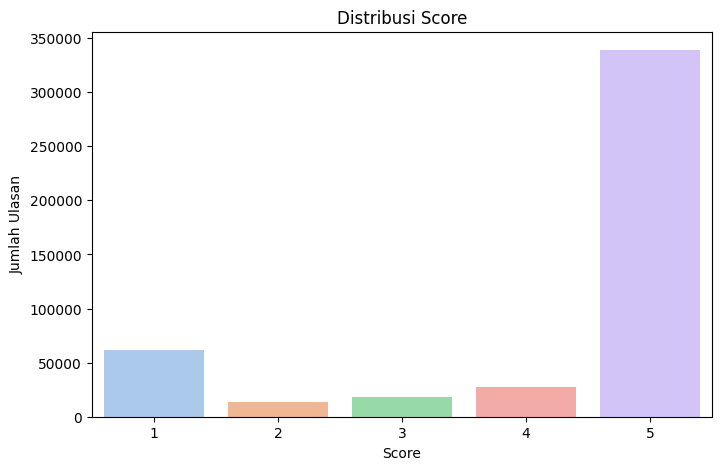

In [113]:
# Menampilkan grafik persebaran score berdasarkan ulasan pengguna
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='score', palette='pastel')
plt.title('Distribusi Score')
plt.xlabel('Score')
plt.ylabel('Jumlah Ulasan')
plt.show()

Berdasarkan distribusi skor, sebagian besar pengguna memberikan rating 5. Hal ini mengindikasikan tingkat kepuasan yang tinggi terhadap layanan yang disediakan oleh aplikasi TikTok.

In [114]:
sample_result_clean = sample_result.dropna(subset=['sentiment', 'focus_areas']).copy()

/tmp/ipython-input-115-1111765210.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




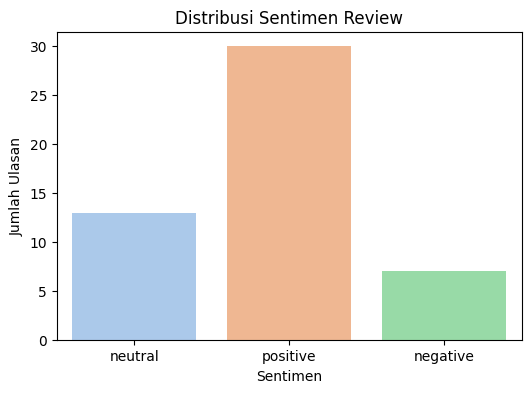

In [115]:
plt.figure(figsize=(6, 4))
sns.countplot(data=sample_result, x='sentiment', palette='pastel')
plt.title("Distribusi Sentimen Review")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.show()

Berdasarkan grafik di atas, mayoritas ulasan pengguna menunjukkan sentimen positif. Sentimen netral menempati posisi kedua, sementara sentimen negatif merupakan yang paling sedikit. Temuan ini mengindikasikan bahwa secara umum pengguna memiliki persepsi yang cukup baik terhadap aplikasi, meskipun masih terdapat beberapa kritik yang perlu menjadi perhatian pengembang.

In [116]:
sample_result_clean['focus_areas'] = sample_result_clean['focus_areas'].apply(
    lambda x: [tag.strip().lower() for tag in x.split(',') if tag.strip()]
)

In [117]:
focus_exploded = sample_result_clean.explode('focus_areas')

# Hapus baris dengan focus_areas kosong setelah explode
focus_exploded = focus_exploded[focus_exploded['focus_areas'].str.strip() != '']
focus_exploded = focus_exploded.dropna(subset=['focus_areas'])

focus_exploded = focus_exploded[focus_exploded['focus_areas'].str.lower() != 'n/a']
focus_exploded = focus_exploded[focus_exploded['focus_areas'].str.lower() != 'na']

focus_rating_counts = focus_exploded.groupby(['sentiment', 'focus_areas']).size().reset_index(name='count')
total_focus_counts = focus_exploded['focus_areas'].value_counts().reset_index()
total_focus_counts.columns = ['focus_areas', 'total_count']

focus_rating_counts = pd.merge(focus_rating_counts, total_focus_counts, on='focus_areas')

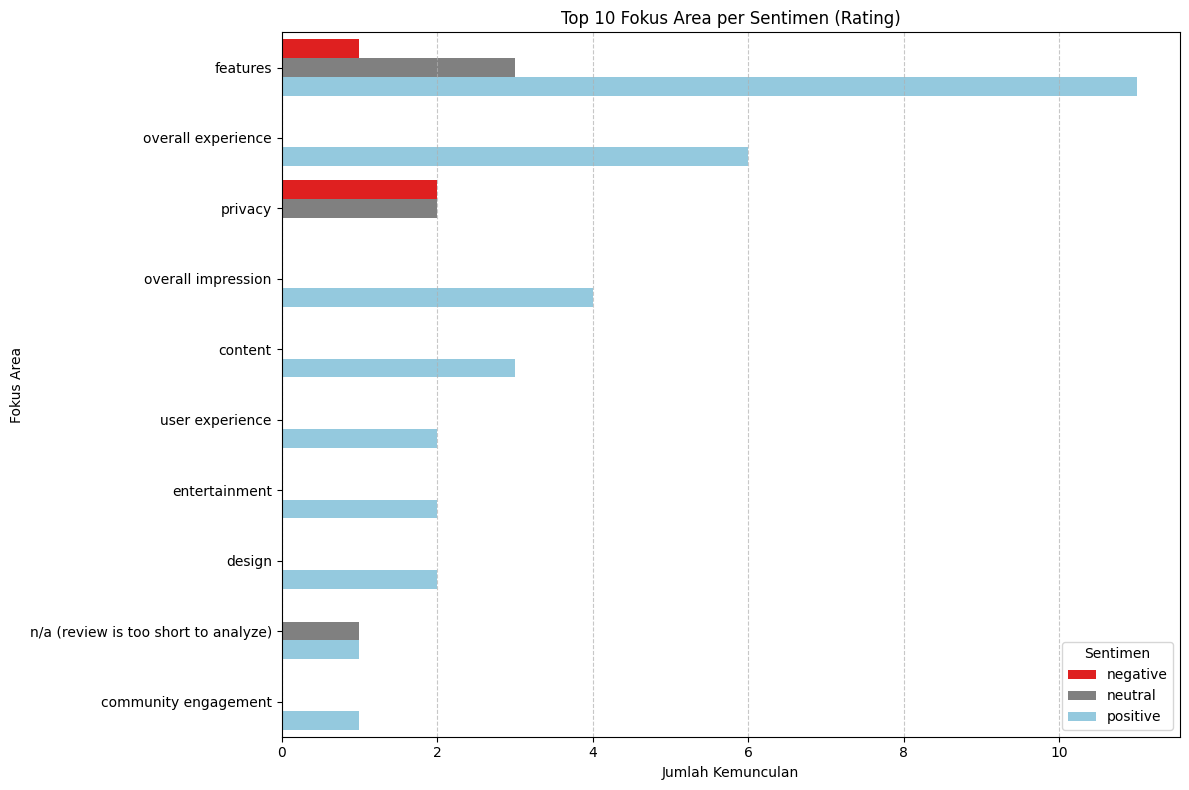

In [118]:
top_n = 10 # Anda bisa ubah angka ini
top_focus_areas = total_focus_counts.head(top_n)['focus_areas'].tolist()

# Filter DataFrame hanya untuk top focus areas
focus_rating_counts_top = focus_rating_counts[focus_rating_counts['focus_areas'].isin(top_focus_areas)].copy()

# Urutkan berdasarkan total_count untuk mempertahankan urutan di plot
focus_rating_counts_top['focus_areas'] = pd.Categorical(
    focus_rating_counts_top['focus_areas'],
    categories=top_focus_areas,
    ordered=True
)
focus_rating_counts_top = focus_rating_counts_top.sort_values('focus_areas')

#Visualisasi
plt.figure(figsize=(12, 8))
sns.barplot(
    data=focus_rating_counts_top,
    x='count',
    y='focus_areas',
    hue='sentiment',
    palette=['red','gray', 'skyblue'],
    orient='h' # Horizontal bar plot
)

plt.title(f"Top {top_n} Fokus Area per Sentimen (Rating)")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Fokus Area")
plt.legend(title="Sentimen")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Berdasarkan grafik di atas, dapat diidentifikasi sepuluh fokus utama yang sering muncul dalam ulasan pengguna berdasarkan sentimen. Area features menjadi area yang paling sering disebutkan dalam ulasan pengguna.

Adanya sentimen negatif pada beberapa aspek menunjukkan bahwa masih diperlukan perbaikan, meskipun sentimen positif tetap menjadi yang paling dominan.

/tmp/ipython-input-119-1190659294.py:23: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




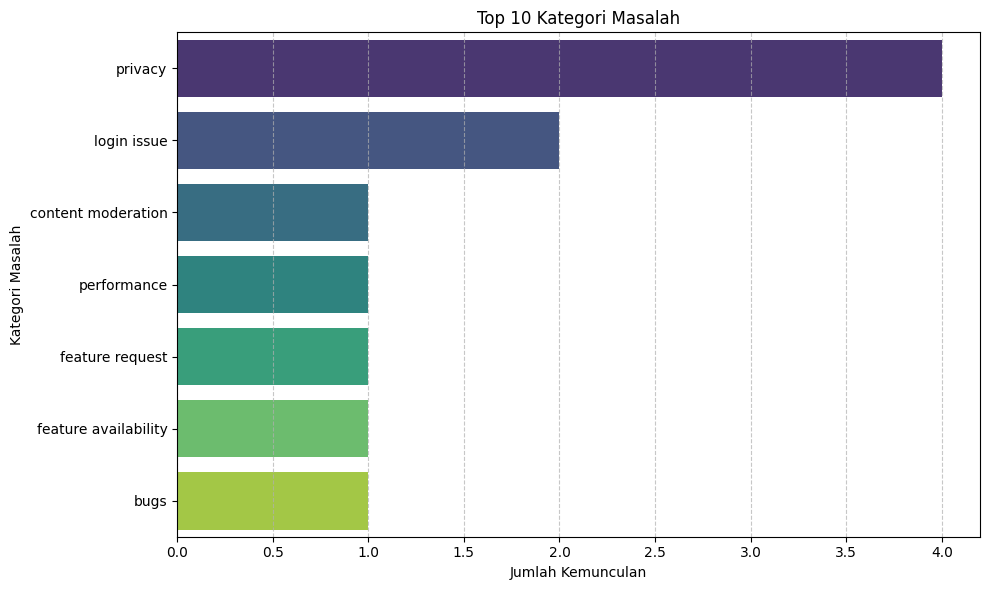

In [119]:
# Ganti 'n/a', 'na', 'N/A', 'NA', None, '(none)' dengan NaN, lalu hapus baris dengan NaN di kolom problem_category
problem_df = sample_result_clean.copy()
problem_df['problem_category'] = problem_df['problem_category'].replace(['n/a', 'na', 'N/A', 'NA', 'none', '(none)'], pd.NA)
problem_df = problem_df.dropna(subset=['problem_category'])

# Split string problem_category jika ada multiple categories dipisahkan koma
problem_df['problem_category'] = problem_df['problem_category'].str.split(',')
problem_exploded = problem_df.explode('problem_category')
problem_exploded['problem_category'] = problem_exploded['problem_category'].str.strip().str.lower()

# Hapus lagi jika ada nilai kosong setelah split dan strip
problem_exploded = problem_exploded[problem_exploded['problem_category'] != '']

# Hitung Frekuensi
problem_counts = problem_exploded['problem_category'].value_counts()

# Pilih Top N
top_n_problems = 10
top_problems = problem_counts.head(top_n_problems)

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(x=top_problems.values, y=top_problems.index, palette='viridis')
plt.title(f"Top {top_n_problems} Kategori Masalah")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Kategori Masalah")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Berdasarkan grafik di atas, masalah yang paling sering muncul dalam ulasan pengguna berkaitan dengan isu privacy. Oleh karena itu, pengembang perlu memberikan perhatian lebih terhadap masalah ini agar pengalaman pengguna dapat ditingkatkan. Selain privacy, isu seperti login issue dan content moderation juga cukup sering disebutkan, menunjukkan adanya kebutuhan akan peningkatan pada aspek tersebut.

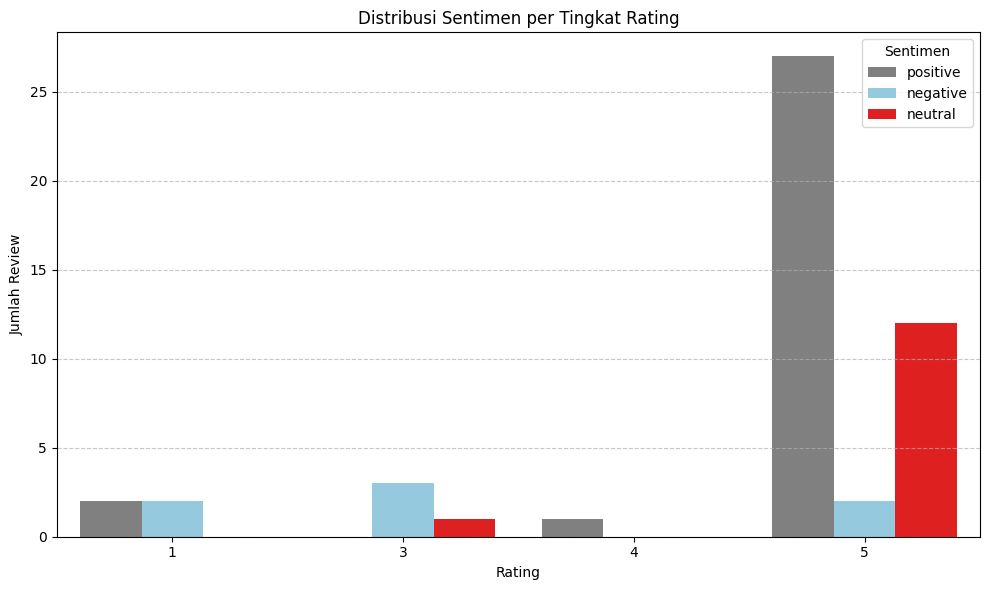

In [120]:
# Ganti nilai non-finite (NaN, inf) di kolom 'score' dengan NaN dan hapus barisnya
sample_result_cleaned_score = sample_result.dropna(subset=['score']).copy()

# Urutkan rating agar tampil berurutan di plot
sample_result_cleaned_score['score'] = sample_result_cleaned_score['score'].astype(int)
sample_result_sorted = sample_result_cleaned_score.sort_values('score')

plt.figure(figsize=(10, 6))
sns.countplot(data=sample_result_sorted, x='score', hue='sentiment', palette=['gray', 'skyblue', 'red']) # Menggunakan palette yang sudah disesuaikan
plt.title("Distribusi Sentimen per Tingkat Rating")
plt.xlabel("Rating")
plt.ylabel("Jumlah Review")
plt.legend(title="Sentimen")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [121]:
print("Value counts for the 'score' column in sample_result_cleaned_score:")
display(sample_result_cleaned_score['score'].value_counts().sort_index())

Value counts for the 'score' column in sample_result_cleaned_score:


,count
score,
1,4
3,4
4,1
5,41


# 🔝**Top Keyword**

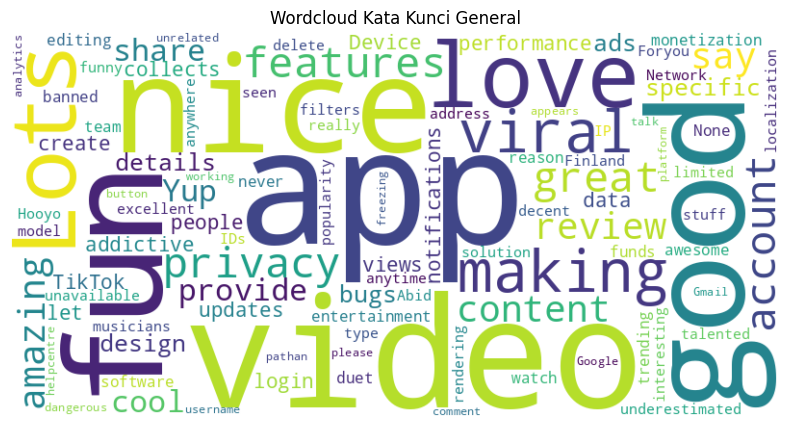

In [126]:
# Combine keywords from all reviews
all_keywords = ' '.join(sample_result_clean['keywords'].dropna().astype(str))

# Generate Wordcloud
wordcloud_general = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(all_keywords)
# Visualize
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_general, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud Kata Kunci General')
plt.show()

Wordcloud di atas menampilkan kata kunci yang paling sering muncul dalam ulasan aplikasi TikTok di Google Play Store. Kata-kata seperti ‘app’, ‘video’, dan ‘nice’ mendominasi, yang menunjukkan bahwa pengguna sering membicarakan fitur aplikasi, konten video yang tersedia, dan kualitas aplikasi secara umum. Ini mencerminkan fokus pengguna pada pengalaman menggunakan aplikasi secara keseluruhan.

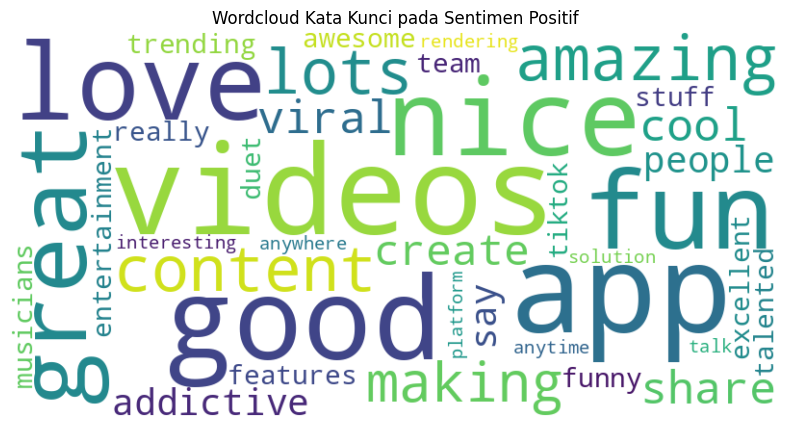

In [130]:
positive_reviews = sample_result_clean[sample_result_clean['sentiment'] == 'positive'].copy()

positive_reviews['keywords'] = positive_reviews['keywords'].fillna('').astype(str)
all_positive_keywords = ' '.join(positive_reviews['keywords'])

all_positive_keywords = all_positive_keywords.lower()

if all_positive_keywords:
    wordcloud_positive = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(all_positive_keywords)
    # Visualisasi
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_positive, interpolation='bilinear')
    plt.axis('off')
    plt.title('Wordcloud Kata Kunci pada Sentimen Positif')
    plt.show()
else:
    print("Tidak ada kata kunci yang ditemukan pada review dengan sentimen positif.")

Wordcloud di atas menampilkan kata kunci yang sering muncul dalam ulasan dengan sentimen positif. Kata seperti ‘good’, ‘videos’, ‘nice’, ‘love’, dan ‘great’ mendominasi, yang mengindikasikan bahwa banyak pengguna merasa puas dengan fitur dan konten aplikasi. Kata-kata ini mencerminkan pengalaman yang menyenangkan serta apresiasi terhadap kualitas layanan dan hiburan yang diberikan TikTok.

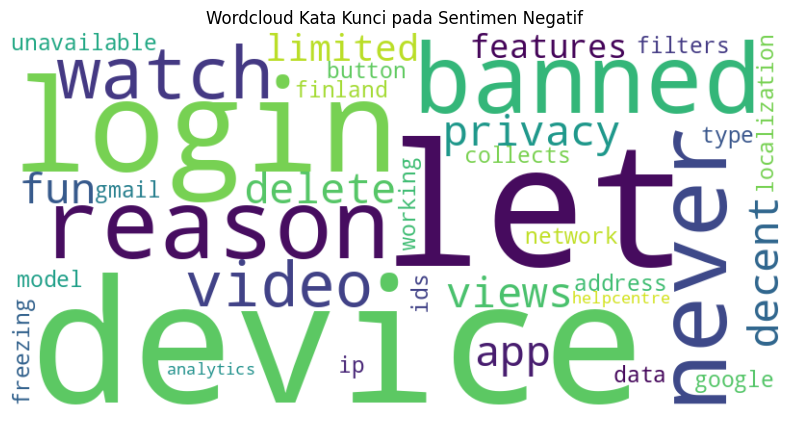

In [133]:
negative_reviews = sample_result_clean[sample_result_clean['sentiment'] == 'negative'].copy()

negative_reviews['keywords'] = negative_reviews['keywords'].fillna('').astype(str)
all_negative_keywords = ' '.join(negative_reviews['keywords'])

all_negative_keywords = all_negative_keywords.lower()

if all_negative_keywords:
  wordcloud_negative = WordCloud(
      width=800,
      height=400,
      background_color='white',
      colormap='viridis'
      ).generate(all_negative_keywords)
    # Visualisasi
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud_negative, interpolation='bilinear')
  plt.axis('off')
  plt.title('Wordcloud Kata Kunci pada Sentimen Negatif')
  plt.show()
else:
    print("Tidak ada kata kunci yang ditemukan pada review dengan sentimen negatif.")

Wordcloud di atas menampilkan kata kunci yang sering muncul dalam ulasan dengan sentimen negatif. Kata seperti ‘device’, ‘let’, dan ‘login’ mendominasi, yang menunjukkan bahwa banyak keluhan pengguna berkaitan dengan masalah teknis, seperti kesulitan login, keterbatasan perangkat, hingga pembatasan akses aplikasi. Hal ini menunjukkan area yang perlu diperbaiki untuk meningkatkan pengalaman pengguna.

# 📊 **Hasil Analisis Ulasan Pengguna TikTok**

### 🪄 Analisis Sentimen
- Sebagian besar ulasan pengguna memiliki sentimen positif, menunjukkan kepuasan terhadap kualitas dan kinerja aplikasi TikTok.
- Sentimen negatif berkaitan dengan keluhan teknis, meliputi:
  - Kendala saat login.
  - Pembatasan atau penguncian akun.
  - Masalah kompatibilitas aplikasi dengan perangkat tertentu.

### 🔍 Topik Utama yang Disoroti
- Topik yang paling banyak dibahas oleh pengguna mencakup:
  - Fitur aplikasi.
  - Ketersediaan dan kualitas video.
  - Pengalaman penggunaan secara umum.
- Ulasan positif cenderung menyoroti:
  - Kualitas konten video.
  - Kemudahan penggunaan fitur.
  - Kenyamanan dan tampilan antarmuka.
- Ulasan negatif menyoroti:
  - Masalah pada perangkat.
  - Kesulitan dalam proses login.
  - Pembatasan akses yang dirasakan tidak adil.

### 🔠 Temuan Visualisasi Wordcloud
- **Ulasan Positif**: Kata seperti `"good"`, `"videos"`, `"nice"`, dan `"love"` mendominasi, mencerminkan kepuasan terhadap konten dan fitur aplikasi.
- **Ulasan Negatif**: Kata seperti `"device"`, `"let"`, dan `"login"` paling sering muncul, menunjukkan adanya hambatan teknis dan masalah aksesibilitas.



# 📈**REKOMENDASI**

Berdasarkan keseluruhan hasil EDA terhadap ulasan pengguna TikTok di Google Play Store, berikut adalah rekomendasi strategi yang dapat dilakukan oleh developer untuk meningkatkan kualitas dan kepuasan pengguna.

1. **Perbaikan Teknis Aplikasi** \
Problem: Berdasarkan keyword 'device', 'login', 'banned', 'limited', dan 'let' yang muncul dominan pada sentimen negatif.
Rekomendasi: developer dapat meningkatkan stabilitas dan kompatibilitas aplikasi di berbagai jenis perangkat, menyederhanakan proses login dan menangani isu akun yang terkunci atau terblokir secara tidak wajar, menyediakan sistem notifikasi atau penjelasan lebih detail ketika akun ter-banned agar pengguna memahami jelas alasan yang terjadi.

2. ** Peningkatan Privasi dan Perlindungan Data** \
Problem: Berdasarkan keyword 'privacy', 'data', 'collects', dan 'analytics'
Rekomendasi: Menampilkan transparansi lebih lanjut terkait kebijakan pengumpulan data, menawarkan pengaturan privasi yang lebih fleksibe dan mudah diakses, memberikan pengamanan ganda pada saat pembuatan akun, Mengedukasi pengguna mengenai bagaimana data digunakan.

3. **Fokus pada Kualitas dan Inovasi Konten**
Insight: Keyword seperti 'videos', 'fun', 'content', 'viral', 'entertainment' banyak muncul dalam sentimen positif dan umum.
Rekomendasi: Terus kembangkan inovasi fitur video yang kreatif (seperti duet, efek, filter) dan fitur-fitur lain yang digemari pengguna, Mengembangkan algoritma yang lebih adil agar kreator baru mempunyai kesempatan untuk lebih dikenal.

4. **Mempertahankan Pengalaman Positif Pengguna** \
Insight: Keyword seperti  'nice', 'good', 'love', 'great', dan 'amazing' yang mendominasi sentimen positif.
Rekomendasi: Mempertahankan elemen-elemen yang telah disenangi pengguna, seperti desain yang ramh, fitur-fitur editing video, dan interaksi sosial, Mengembangkan fitur komunitas atau reward bagi pengguna yang telah menjadi top content creator.

5. **Menambahkan Tanggapan Cepat Terhadap Masukan** \
Problem: Keyword seperti 'bugs', 'updates', 'support', dan 'issues'.
Rekomendasi: Meningkatkan kecepatan respon terhadap laporan masalah, Menyediakan fitur pelaporan masalah yang lebih mudah dan terintegrasi, Memperbarui rutin yang bukan hanya menambah fitur baru, tetapi juga memperbaiki masalah teknis.

# 📄**KESIMPULAN**

Berdasarkan hasil eksplorasi data analitik terhadap ulasan pengguna aplikasi TikTok di Google Play Store, dapat disimpulkan bahwa mayoritas pengguna memberikan ulasan dengan sentimen positif. Hal ini mengindikasikan bahwa secara umum pengguna merasa puas terhadap kualitas aplikasi, terutama pada aspek fitur, konten video, dan pengalaman penggunaan secara keseluruhan.

Namun demikian, ulasan dengan sentimen negatif turut mengungkap beberapa isu krusial yang perlu mendapatkan perhatian, seperti permasalahan teknis, kendala dalam proses login, serta pembatasan akses aplikasi. Analisis fokus area melalui wordcloud kata kunci memperkuat temuan ini, di mana kata seperti ‘app’ dan ‘video’ sering disorot oleh pengguna secara umum. Sementara itu, kata-kata seperti ‘device’, ‘let’, dan ‘login’ mendominasi ulasan negatif, yang mencerminkan keluhan pengguna terhadap aspek teknis dan aksesibilitas. Sebaliknya, kata seperti ‘good’, ‘videos’, ‘nice’, ‘love’, dan ‘great’ banyak muncul pada ulasan positif, menandakan tingkat kepuasan yang tinggi terhadap konten dan fitur aplikasi.

Berdasarkan temuan tersebut, beberapa rekomendasi dapat diberikan kepada developer untuk meningkatkan kualitas layanan aplikasi, termasuk peningkatan stabilitas teknis, penyederhanaan proses login, perbaikan sistem akses, serta pelestarian fitur-fitur yang telah mendapatkan apresiasi dari pengguna.

Dengan pendekatan berbasis data ini, developer TikTok dapat memperoleh pemahaman yang lebih mendalam mengenai kebutuhan dan keluhan pengguna. Hal ini akan mendukung pengambilan keputusan yang lebih tepat sasaran dalam pengembangan produk, serta mendorong peningkatan kualitas aplikasi yang berfokus pada pengalaman dan kepuasan pengguna.